# Feature engineering 1: From variables to features

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

## Data exploration
Let's look at some descriptive statistics of this dataset as well as the unique values for the categorical columns.

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,1000,NaN,NaN,NaN,66.089,15.1631,0,57,66,77,100
reading score,1000,NaN,NaN,NaN,69.169,14.6002,17,59,70,79,100
writing score,1000,NaN,NaN,NaN,68.054,15.1957,10,57.75,69,79,100


In [6]:
columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for column in columns:
    print(f'{column}: {np.unique(df[column])}')

gender: ['female' 'male']
race/ethnicity: ['group A' 'group B' 'group C' 'group D' 'group E']
parental level of education: ["associate's degree" "bachelor's degree" 'high school' "master's degree"
 'some college' 'some high school']
lunch: ['free/reduced' 'standard']
test preparation course: ['completed' 'none']


## Outliers
I will use the Tukey method to remove the outliers seen at the lower end.

In [7]:
thresholds = {
    'tukey': 1.5
}

In [8]:
def apply_tukey(df, column, thresh=1.5):
    q75, q25 = np.percentile(df[column], [75, 25])
    iqr = q75 - q25
    min_value = q25 - thresh*iqr
    max_value = q75 + thresh*iqr
    df[f'tukey_{column}'] = df[column].apply(lambda x: np.min([x, max_value]))
    df[f'tukey_{column}'] = df[f'tukey_{column}'].apply(lambda x: np.max([x, min_value]))
    return df

In [9]:
def correct_outliers(df, column_list):
    for column in column_list:
        # Tukey
        df = apply_tukey(df, column, thresh=thresholds['tukey'])
        
    return df

In [10]:
columns = ['math score', 'reading score', 'writing score']
df = correct_outliers(df, columns)

## Feature Engineering
### Exam score distributions

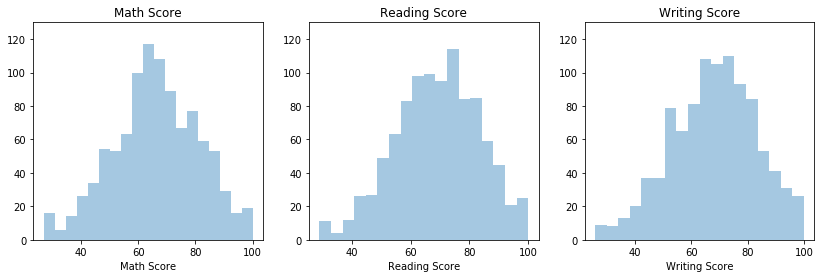

In [11]:
scores = ['tukey_math score', 'tukey_reading score', 'tukey_writing score']
score_labels = [x.split('_')[-1].title() for x in scores]

f, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, score_type in enumerate(scores):
    sns.distplot(df.loc[:, score_type], ax=axes[i], kde=False)
    axes[i].set_xlabel(score_labels[i])
    axes[i].set_ylim([0, 130])
    axes[i].set_title(f'{score_labels[i]}')
        
plt.show()

### Test for normality

In [12]:
for score_type in scores:
    normal_stat, pval = normaltest(df[score_type])
    print(f"The probability that the {score_type.split('_')[-1].title()} distribution is normal is {pval:0.4f}.")

The probability that the Math Score distribution is normal is 0.0509.
The probability that the Reading Score distribution is normal is 0.0064.
The probability that the Writing Score distribution is normal is 0.0021.


**Observations:**

The distributions appear close to normal, but a little right skewed. In addition, all scores, except the math score have a p-value below 0.05, indicating that they are not normal distributions.

### Box-Cox transformation

Let's apply a Box-Cox transformation and see if these distributions become more normal.

In [13]:
for score_type in scores:
    boxcox_transform, _ = boxcox(df[score_type])
    df[f'boxcox_{score_type}'] = boxcox_transform

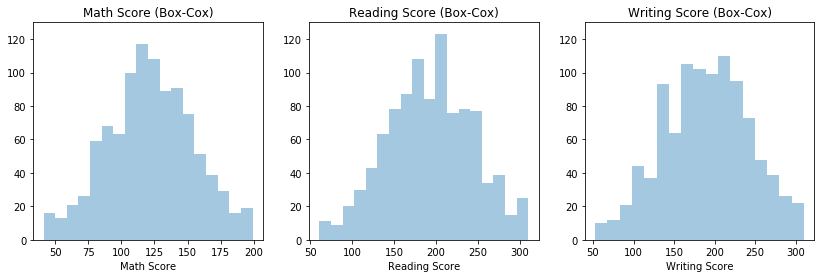

In [14]:
boxcox_columns = [f'boxcox_{x}' for x in scores]

f, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, column in enumerate(boxcox_columns):
    sns.distplot(df.loc[:, column], ax=axes[i], kde=False)
    axes[i].set_xlabel(score_labels[i])
    axes[i].set_ylim([0, 130])
    axes[i].set_title(f'{score_labels[i]} (Box-Cox)')
        
plt.show()

In [15]:
print('After Box-Cox transformation...')
for score_type in scores:
    normal_stat, pval = normaltest(df[f'boxcox_{score_type}'])
    print(f"The probability that the {score_type.split('_')[-1].title()} distribution is normal is {pval:0.4f}.")

After Box-Cox transformation...
The probability that the Math Score distribution is normal is 0.0919.
The probability that the Reading Score distribution is normal is 0.0162.
The probability that the Writing Score distribution is normal is 0.0051.


**Observations:** The histograms are now appear more normal after applying a Box-Cox transformation. In addition, the p-values for the normal test are higher, all though the reading score and writing score distributions still have p-values below 0.05.

## Weighted averages
Compute weighted average for scores. Since the reading and writing scores are highly correlated, I will give less weight to these scores and more weight to math scores.

In [16]:
math_scores = df['boxcox_tukey_math score'].values
reading_scores = df['boxcox_tukey_reading score'].values
writing_scores = df['boxcox_tukey_writing score'].values

In [17]:
df['weighted_averaged_scores'] = math_scores*0.5 + reading_scores*0.25 + writing_scores*0.25
df['averaged_scores'] = (math_scores + reading_scores + writing_scores) / 3

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
math score,1000.0,66.089000,15.163080,0.000000,57.000000,66.000000,77.000000,100.000000
reading score,1000.0,69.169000,14.600192,17.000000,59.000000,70.000000,79.000000,100.000000
writing score,1000.0,68.054000,15.195657,10.000000,57.750000,69.000000,79.000000,100.000000
tukey_math score,1000.0,66.165000,14.922414,27.000000,57.000000,66.000000,77.000000,100.000000
tukey_reading score,1000.0,69.201000,14.503481,29.000000,59.000000,70.000000,79.000000,100.000000
tukey_writing score,1000.0,68.094375,15.068368,25.875000,57.750000,69.000000,79.000000,100.000000
boxcox_tukey_math score,1000.0,122.214196,32.550616,41.353891,101.646608,121.138988,145.645803,198.964999
boxcox_tukey_reading score,1000.0,193.324839,52.026455,61.125252,155.492055,194.513294,227.873820,310.149029
boxcox_tukey_writing score,1000.0,189.528571,53.734994,52.583508,151.223564,190.926982,227.927635,310.226981
weighted_averaged_scores,1000.0,156.820450,40.516933,49.104136,128.536166,157.446337,185.251233,254.576502


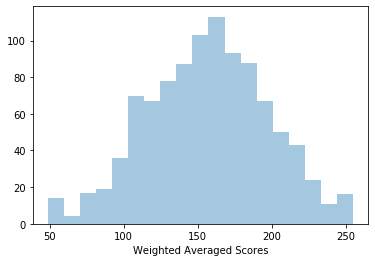

In [19]:
sns.distplot(df.loc[:, 'weighted_averaged_scores'], kde=False)
plt.xlabel('Weighted Averaged Scores')
        
plt.show()

TODO: Try transforming scores using logs.

In [20]:
normal_stat, pval = normaltest(df.loc[:, 'weighted_averaged_scores'])
print(f'There is a {pval:0.3f} probability that this distribution is normal.')

There is a 0.054 probability that this distribution is normal.


**Observations:**

The distribution of _weighted\__average\__scores_ looks normal, so I will not apply a Box-Cox transformation. The high p-value for the normal test is also a good indication that this is a normal distribution.

## Good predictors
I will now explore which variables are strongly related to the new _weighted\__average\__scores_ variable and would be good to use as predictors.

In [21]:
def plot_category_distributions(df, category):
    scores = ['tukey_math score', 'tukey_reading score', 'tukey_writing score']
    score_labels = [x.split('_')[-1].title() for x in scores]

    f, axes = plt.subplots(1, 3, figsize=(14, 4))

    for i, score_type in enumerate(scores):
        for cat_type in df[category].unique():
            sns.distplot(df.loc[df[category] == cat_type, score_type], ax=axes[i], kde=False)
        axes[i].legend(df[category].unique())
        axes[i].set_xlabel(score_labels[i])
        axes[i].set_ylim([0, 130])
        axes[i].set_title(f'{category.title()} vs. {score_labels[i]}')

    plt.show()

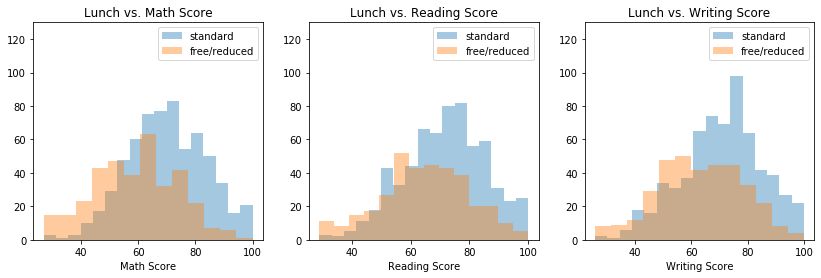

In [22]:
plot_category_distributions(df, 'lunch')

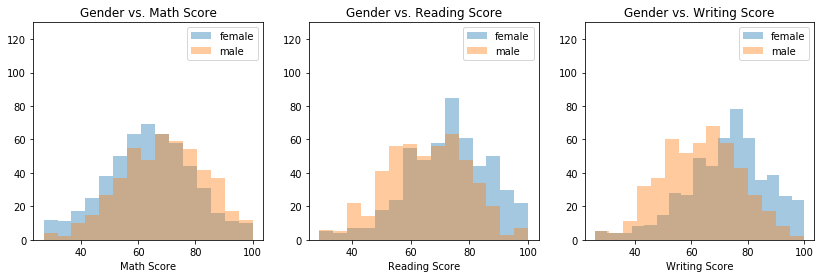

In [23]:
plot_category_distributions(df, 'gender')

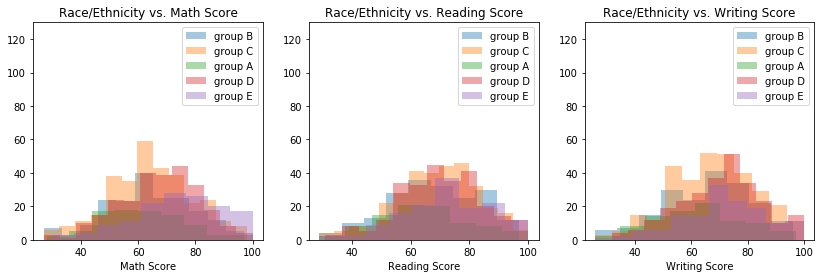

In [24]:
plot_category_distributions(df, 'race/ethnicity')

TODO: Compare groups in pairs. Store in list and plot.
TODO: Use box plot instead.

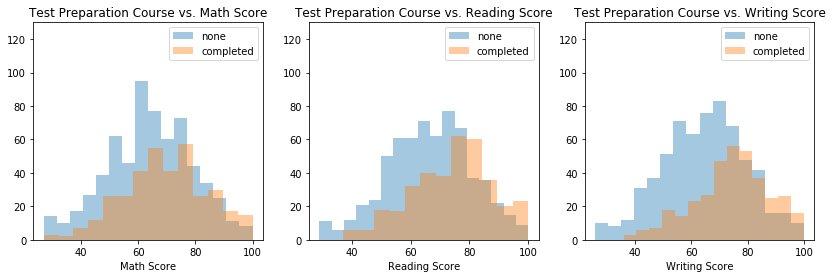

In [25]:
plot_category_distributions(df, 'test preparation course')

TODO: Test distributions with t-test.